### demonstrating AprilTags  20221221 CJH
* found at least two libraries - apriltags and pupil-apriltags
* first needs cmake installed on windows, second has another issue
  * so pip fails on one, succeds on the other
* seems to be an issue loading pupil-apriltags on windows
  * dll issues cause problems with python 3.8+ and pupil_apiltags
  * for now I just made a 3.7 environment
* probably works just fine on linux / ras pi

#### import the necessary libraries

In [7]:
from pupil_apriltags import Detector  # apriltag processor
import cv2  # image acquisition and manipulation
import matplotlib.pyplot as plt

In [8]:
# create a detector object
at_detector = Detector(
   families="tag16h5",
   nthreads=2,
   quad_decimate=1.0,
   quad_sigma=0.0,
   refine_edges=1,
   decode_sharpening=0.25,
   debug=0
)

In [19]:
# cameras I have calibrated
camera_params = {'logitech_c290':[2589.21, 2570.98, 227.20, 228.82]}
tag_size = 0.1524  # that's how many meters across we are

#### get an image from camera  - can be webcam or external USB
* you can skip this if you want to use the same image I did - it's saved on the disk; see below

In [92]:
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # open a regular USB cam
s, image_raw = cam.read()  # read from the camera
if s > 0:  # test if the camera actually returned a success
    cv2.imshow(f'Image Processing Pipeline', image_raw)
cam.release()
# close video display on key press
cv2.waitKey(0)
cv2.destroyAllWindows()

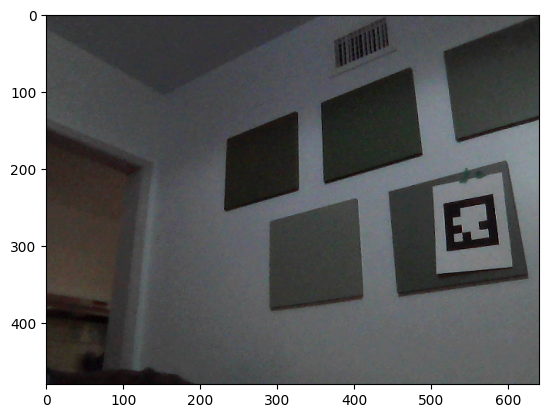

In [100]:
plt.imshow(image_raw)

In [124]:
# in case we need it later
save_images = False
if save_images:
    plt.imsave('16h5_test.png', image_raw)
    cv2.imwrite('16h5_test_cv.png', image_raw)

In [12]:
# I want to keep looking at these images
load_images = True
if load_images:
    image_raw = cv2.imread('16h5_test_cv.png')

In [13]:
# this detector fails on color images
grey_image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2GRAY)

In [17]:
%%time 
detections = at_detector.detect(grey_image)
detections[1]

Wall time: 19 ms


Detection object:
tag_family = b'tag16h5'
tag_id = 5
hamming = 0
decision_margin = 44.500694274902344
homography = [[ 1.51865016e+01 -1.22607599e+01  5.50055928e+02]
 [-1.42418118e+01  2.43586992e+01  2.70940065e+02]
 [-3.23689063e-02 -2.78086721e-02  1.00000000e+00]]
center = [550.0559278  270.94006509]
corners = [[520.23626709 308.13540649]
 [588.38952637 299.05325317]
 [580.14880371 233.40393066]
 [516.07409668 246.01838684]]
pose_R = None
pose_t = None
pose_err = None

In [21]:
%%time 
detections = at_detector.detect(grey_image, estimate_tag_pose=True, camera_params=camera_params['logitech_c290'], tag_size=tag_size)
detections[1]

Wall time: 27 ms


Detection object:
tag_family = b'tag16h5'
tag_id = 5
hamming = 0
decision_margin = 44.500694274902344
homography = [[ 1.51865016e+01 -1.22607599e+01  5.50055928e+02]
 [-1.42418118e+01  2.43586992e+01  2.70940065e+02]
 [-3.23689063e-02 -2.78086721e-02  1.00000000e+00]]
center = [550.0559278  270.94006509]
corners = [[520.23626709 308.13540649]
 [588.38952637 299.05325317]
 [580.14880371 233.40393066]
 [516.07409668 246.01838684]]
pose_R = [[ 0.92710269  0.04545455  0.37204097]
 [-0.16803994  0.93767536  0.30418334]
 [-0.33502713 -0.34452693  0.87695953]]
pose_t = [[0.72317983]
 [0.09605335]
 [5.78185551]]
pose_err = 2.644900457558637e-05

In [95]:
grey_image.shape

(480, 640)

In [103]:
# process our image with the info from detector
def pipeline(img):
    img_copy = img.copy()
    grey_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detections = at_detector.detect(grey_image)
    for idy, detection in enumerate(detections):
        color = ([255*int(i) for i in f'{(idy+1) % 7:03b}'])  # trick for unique colors
        center = [int(c) for c in detection.center]
        corners = [ [int (c) for c in corner] for corner in detection.corners ]
        corners = sorted(corners, key=lambda x: (x[1], x[0] ))
        corners[2], corners[3] = corners[3], corners[2]
        for idx, corner in enumerate(corners):
            img_copy = cv2.line(img_copy, corner, corners[(idx+1)%4], color, 2)
        img_copy = cv2.putText(img_copy, f'{detection.tag_id:2d}', center, cv2.FONT_HERSHEY_SIMPLEX,1, color, 2)   
    return img_copy

In [97]:
cv2.imshow('Processed', pipeline(image_raw))
cv2.waitKey(0)
cv2.destroyAllWindows()

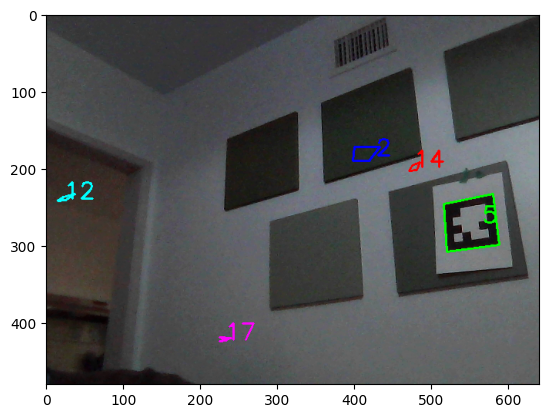

In [104]:
plt.imshow(pipeline(image_raw))

In [111]:
print('Summary of results')
for d in detections:
    print(f'ID: {d.tag_id:2}    hamming: {d.hamming}   decision_margin: {d.decision_margin:2.2f}')

Summary of results
ID:  2    hamming: 2   decision_margin: 0.95
ID:  5    hamming: 0   decision_margin: 44.50
ID: 12    hamming: 2   decision_margin: 1.07
ID: 14    hamming: 2   decision_margin: 1.45
ID: 17    hamming: 1   decision_margin: 0.90


#### tricks to get things to work

In [21]:
corners = [ [int (c) for c in corner] for corner in d[0].corners ]
corners

[[532, 293], [607, 283], [597, 214], [526, 227]]

In [27]:
sorted(corners, key=lambda x: (x[1], x[0] ))

[[597, 214], [526, 227], [607, 283], [532, 293]]

In [117]:
# color trick
for ix in range(8):
    color = ([255*int(i) for i in f'{(ix+1) % 7:03b}'])
    print(color, )

[0, 0, 255]
[0, 255, 0]
[0, 255, 255]
[255, 0, 0]
[255, 0, 255]
[255, 255, 0]
[0, 0, 0]
[0, 0, 255]
